<a href="https://colab.research.google.com/github/MohammadParsaTheFirst/Deep-generative-models-course/blob/main/CHW3/DGM_HW3_GAN_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3: Generative Adversarial Networks
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [ ]:
name = 'MohammadParsa Dini'
std_id = '400101204'

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

if torch.cuda.is_available():
    torch.device = 'cuda'
else:
    torch.device = 'cpu'

device = torch.device
print(f'running on {device}')

running on cuda


### In this notebook, you will implement the required components from scratch, without code completion. Utilize `torch` to create models and perform optimization. The goal of this assignment is to implement Deep Convolutional Generative Adversarial Networks (DC-GAN) using the MNIST dataset and to explore interpolation in the latent space.

### To get started, please read the DC-GAN paper available at this link: [DC-GAN Paper](https://arxiv.org/abs/1511.06434v2).


### Part 1. Load the MNIST dataset.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMAGE_SIZE = 28
CHANNELS_IMG = 1
BATCHSIZE = 128

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
    )
])

# trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.73MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Part 2: Build the Generator and Discriminator models.
Build the models with the architecture guidelines for stable training as described in the paper. It is recommended to use the model parameters presented in `config.yaml`, but you are free to choose any set of parameters you prefer.


In [ ]:
import yaml
from pprint import pprint

file_path = 'config.yaml'

with open(file_path, 'r') as file :
    config = yaml.safe_load(file)

pprint(config)

{'model_params': {'discriminator_channels': [128, 256, 512],
                  'discriminator_kernels': [4, 4, 4, 4],
                  'discriminator_paddings': [1, 1, 1, 1],
                  'discriminator_strides': [2, 2, 2, 2],
                  'generator_channels': [512, 256, 128],
                  'generator_kernels': [4, 4, 4, 4],
                  'generator_output_paddings': [1, 1, 0, 0],
                  'generator_paddings': [1, 1, 1, 1],
                  'generator_strides': [2, 2, 2, 2],
                  'latent_dim': 100}}


In [ ]:
import torch.nn as nn

LEAKY_RELU_SLOPE = 0.2
IMAGE_SIZE = 28
CHANNELS_IMG = 1
MEAN_GAUSSIAN = 0.0
STD_GAUSSIAN = 0.02

class Discriminator(nn.Module):
    def __init__(self, channels_image, feature_disc):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input : N x channels_image x 32 x 32
            nn.Conv2d(channels_image, feature_disc, kernel_size=4, padding=2, stride=1),           # 16 x 16
            nn.LeakyReLU(LEAKY_RELU_SLOPE),                                                        #
            self._block(feature_disc, feature_disc*2, kernel_size=4, stride=2, padding=1),         # 8 x 8
            self._block(feature_disc*2, feature_disc*4, kernel_size=4, stride=2, padding=1),       # 4 x 4
            nn.Conv2d(feature_disc*4, 1, kernel_size=4, stride=2, padding=1),                      # 1 x 1
            nn.Sigmoid(),                                                                          # 1 x 1
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(LEAKY_RELU_SLOPE)
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, channels_image, feature_gen):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # N x features_gen x 1 x 1
            self._block(z_dim, feature_gen*8, kernel_size=4, stride=2, padding=1, output_padding=1),                    # N x features_gen x 4 x 4
            self._block(feature_gen*8, feature_gen*4, kernel_size=4, stride=2, padding=1, output_padding=1),            # 8 x 8
            self._block(feature_gen*4, feature_gen*2, kernel_size=4, stride=2, padding=1, output_padding=0),            # 16 x 16
            nn.ConvTranspose2d(feature_gen*2, channels_image, kernel_size=4, stride=2, padding=1, output_padding=0),    # 32 x 1
            nn.Tanh()                                                                                                   # [-1,1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding=output_padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)

# def initialize_weights(model):
#     for m in model.isinstance(m , (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
#         nn.init.normal_(m.weight.data, MEAN_GAUSSIAN, STD_GAUSSIAN)
def initialize_weights(model):
    for m in model.modules():  # Iterate through all submodules of the model
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, MEAN_GAUSSIAN, STD_GAUSSIAN)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)  # Initialize biases to 0


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N,1, 1, 1)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(x).shape == (N, in_channels, H, W)

### Part 3: Write a function to train the models using the GAN framework.
You can refer to the slides or the original GAN paper for the training schema: [GAN Paper](https://arxiv.org/abs/1406.2661). Additionally, create a function to generate samples from the model. Ensure to plot a grid of generated samples every n'th epoch.


In [ ]:
from torch.utils.tensorboard import SummaryWriter

LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 28
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_GEN = 64
FEATURES_DISC = 64
BETA1 = 0.500
BETA2 = 0.999

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
criterion = nn.BCELoss()

fixed_noise_z = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    # data flowing from the dataset --> aka real
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise_z = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise_z)

        ### Train Disciminator on ---> max log(D(x)) + log((1-D(G(z))))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.ones_like(disc_fake))
        loss_disc = (loss_disc_fake + loss_disc_real)/2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator on ---> min log((1-D(G(z)))) <-> max log(D(G(z)))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # print losses
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} --- Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
            )
        with torch.no_grad():
            fake = gen(fixed_noise_z)
            # take out up to 32 examples
            img_grid_real = torchvision.utils.make_grid(
                real[:32], normalize=True
            )
            img_grid_fake = torchvision.utils.make_grid(
                fake[:32], normalize=True
            )
            writer_real.add_image("Real", img_grid_real, global_step=step)
            writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        step += 1


Epoch [0/5] Batch 0/469 --- Loss D: 0.6946, Loss G: 0.6904
Epoch [0/5] Batch 100/469 --- Loss D: 0.0676, Loss G: 0.0508
Epoch [0/5] Batch 200/469 --- Loss D: 0.0139, Loss G: 0.0098
Epoch [0/5] Batch 300/469 --- Loss D: 0.0056, Loss G: 0.0038
Epoch [0/5] Batch 400/469 --- Loss D: 0.0029, Loss G: 0.0020
Epoch [1/5] Batch 0/469 --- Loss D: 0.0021, Loss G: 0.0014
Epoch [1/5] Batch 100/469 --- Loss D: 0.0013, Loss G: 0.0009
Epoch [1/5] Batch 200/469 --- Loss D: 0.0009, Loss G: 0.0006
Epoch [1/5] Batch 300/469 --- Loss D: 0.0007, Loss G: 0.0004
Epoch [1/5] Batch 400/469 --- Loss D: 0.0005, Loss G: 0.0003
Epoch [2/5] Batch 0/469 --- Loss D: 0.0005, Loss G: 0.0003
Epoch [2/5] Batch 100/469 --- Loss D: 0.0004, Loss G: 0.0002
Epoch [2/5] Batch 200/469 --- Loss D: 0.0003, Loss G: 0.0002
Epoch [2/5] Batch 300/469 --- Loss D: 0.0002, Loss G: 0.0001
Epoch [2/5] Batch 400/469 --- Loss D: 0.0002, Loss G: 0.0001
Epoch [3/5] Batch 0/469 --- Loss D: 0.0002, Loss G: 0.0001
Epoch [3/5] Batch 100/469 --- Lo

### Part 4: Plot a grid of 100 generated samples.

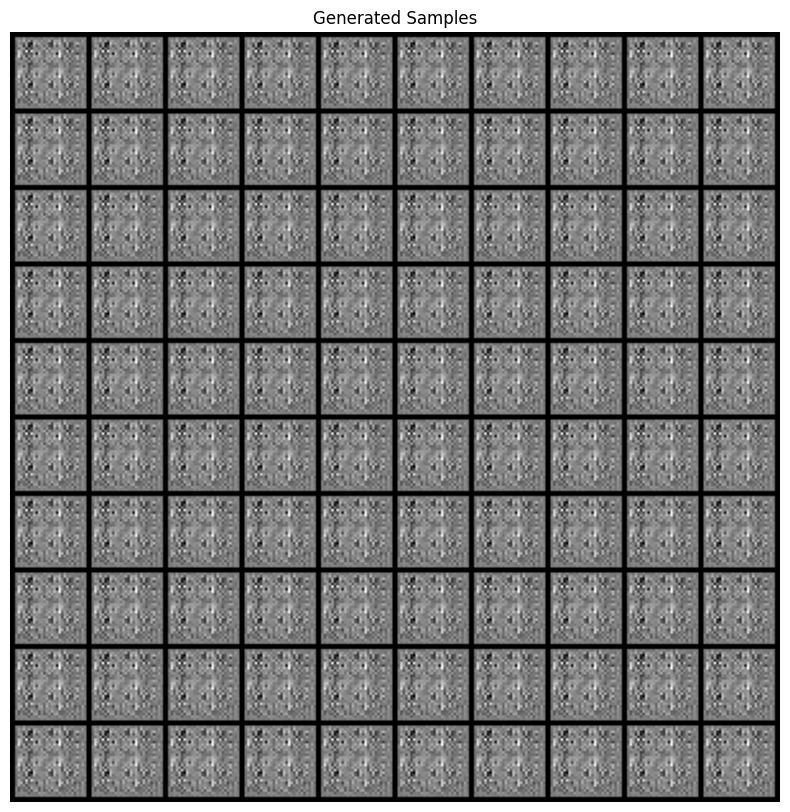

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Generate 100 samples
fixed_noise_z = torch.randn(100, Z_DIM, 1, 1).to(device)
gen.eval()  # Switch generator to evaluation mode
with torch.no_grad():
    generated_images = gen(fixed_noise_z)  # Generate fake images

# Normalize and create grid
generated_images = generated_images * 0.5 + 0.5  # Rescale to [0, 1] for visualization
grid = torchvision.utils.make_grid(generated_images, nrow=10, normalize=True)

# Plot the grid
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Convert to HWC format for plotting
plt.axis("off")
plt.title("Generated Samples")
plt.show()


### Part 5: GAN Inversion
In this part, we aim to find the latent vectors corresponding to the samples in the dataset. First, select a random sample from the real dataset and a random latent vector. Freeze the generator and feed the random latent vector into the Generator. Next, define an MSE or MAE loss between the generated sample and the real sample, and optimize the random latent vector to discover the latent vector that generates the selected real sample.


Iteration [0/500], Loss: 0.157690
Iteration [50/500], Loss: 0.157281
Iteration [100/500], Loss: 0.156924
Iteration [150/500], Loss: 0.156656
Iteration [200/500], Loss: 0.156494
Iteration [250/500], Loss: 0.156372
Iteration [300/500], Loss: 0.156300
Iteration [350/500], Loss: 0.156247
Iteration [400/500], Loss: 0.156222
Iteration [450/500], Loss: 0.156184


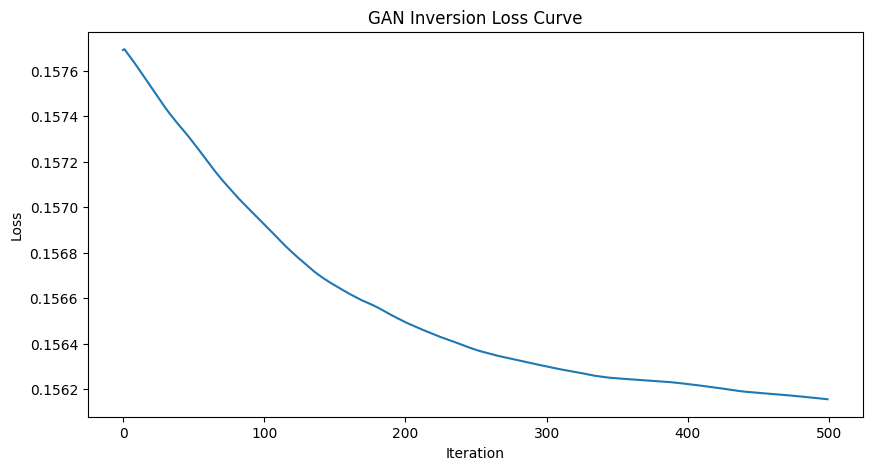

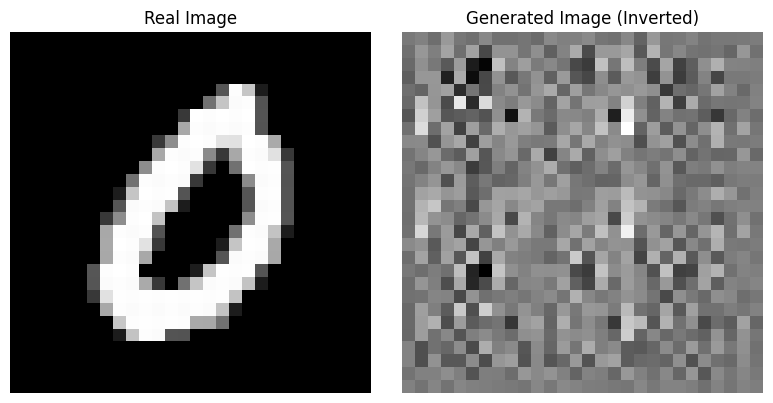

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Select a random real sample from the dataset
real_sample, _ = next(iter(dataloader))  # Get a batch of real images
real_image = real_sample[0:1].to(device)  # Select one image and move to device
real_image = real_image * 0.5 + 0.5  # Normalize for visualization if necessary

# Initialize a random latent vector
z = torch.randn(1, Z_DIM, 1, 1, device=device, requires_grad=True)

# Freeze generator weights
gen.eval()
for param in gen.parameters():
    param.requires_grad = False

# Define optimizer and loss function
optimizer = torch.optim.Adam([z], lr=1e-2)  # Only optimize z
criterion = nn.MSELoss()

# Perform optimization
num_iterations = 500
losses = []

for iteration in range(num_iterations):
    optimizer.zero_grad()

    # Generate an image using the current z
    generated_image = gen(z)

    # Compute loss between generated and real image
    loss = criterion(generated_image, real_image)
    losses.append(loss.item())

    # Backpropagate and update z
    loss.backward()
    optimizer.step()

    # Optionally, clamp z to stay within a reasonable range
    z.data.clamp_(-2, 2)

    # Print progress
    if iteration % 50 == 0:
        print(f"Iteration [{iteration}/{num_iterations}], Loss: {loss.item():.6f}")

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("GAN Inversion Loss Curve")
plt.show()

# Visualize the results
with torch.no_grad():
    generated_image = gen(z)
    generated_image = generated_image * 0.5 + 0.5  # Rescale to [0, 1]

# Plot the real and generated images
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(real_image[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
axs[0].axis("off")
axs[0].set_title("Real Image")

axs[1].imshow(generated_image[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
axs[1].axis("off")
axs[1].set_title("Generated Image (Inverted)")
plt.tight_layout()
plt.show()


### Part 6: Interpolating the Latent Space
In this part, you will interpolate the latent space using a 10 by 10 grid. Start with 4 initial points representing the corners of the square, and then perform linear or spherical interpolation between the latent vectors of these 4 images to fill the circumference of the square.
Next, fill in the rest of the square by interpolating between the latent vectors along the circumference.

If $G$ is the generator, and $z_1$ and $z_2$ are two latent vectors of two images, let $w$ be a parameter that varies between $0$ and $1$. The linearly interpolated sample is generated as:

\begin{equation}
G(w \cdot z_1 + (1 - w) \cdot z_2)\
\end{equation}

Try to select the 4 starting images from those that exhibit distinct features. For example, the two top right corners could be the same digit but one with a thick stroke and the other with a thin stroke, while the other two points should be from a different digit but with varying stroke styles.

### Part 7: Arithmetic Operation in Latent Space
In this part, you will attempt to modify the thickness or thinness of a sample by identifying the direction in the latent space that corresponds to these attributes. Additionally, you can explore changing a digit to another (e.g., transforming a digit into a 3) by finding the direction in the latent space that corresponds to that digit.
